# Cleaning and Balancing

In this notebook I'll walk through my process of cleaning up and pre-processing a dataset, then inspecting the results of the analysis for fairness. In this notebook I'm using the "Adult Income data set" available [here](https://archive.ics.uci.edu/ml/datasets/Adult).

We'll start with a bit of exploratory analysis of the data, examining the distribution of numerical features and seeing which if any should be scaled or tuned.

Then we'll examine the categorical variables, extracting the labels and replacing them with a one-hot encoding.

The data will now be in a reasonable shape for machine learning. We split the data and train a basic decision tree classifier.

Finally we explore the incorrectly classified subset of the data, and examine what factors differentiate this subset from the general population.

In [1]:
from sklearn import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\magfrump\Anaconda2\lib\site-packages\sklearn\lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
C:\Users\magfrump\Anaconda2\lib\site-packages\sklearn\qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


## Data Exploration

The data as provided doesn't seem to include the feature names given in the description, so I've included them manually when reading the csv to a DataFrame.

In [2]:
data = pd.read_csv("AdultIncomeData/adult.data",header=None,index_col=False, names=["age",
"workclass",
"fnlwgt",
'education',
'education-num',
'marital-status',
'occupation',
'relationship','race',
'sex',
"capital-gain",
"capital-loss",
"hours-per-week",
"native-country", "target"])

Describe is generally a good as a first pass at any new dataset. I'm including categorical variables here; while there won't be a huge amount of information easily visible about them it will tell us whether there is any missing data, how many classes there are for each category, and what the most common value is.

In [3]:
print data.describe(include='all')

                 age workclass        fnlwgt education  education-num  \
count   32561.000000     32561  3.256100e+04     32561   32561.000000   
unique           NaN         9           NaN        16            NaN   
top              NaN   Private           NaN   HS-grad            NaN   
freq             NaN     22696           NaN     10501            NaN   
mean       38.581647       NaN  1.897784e+05       NaN      10.080679   
std        13.640433       NaN  1.055500e+05       NaN       2.572720   
min        17.000000       NaN  1.228500e+04       NaN       1.000000   
25%        28.000000       NaN  1.178270e+05       NaN       9.000000   
50%        37.000000       NaN  1.783560e+05       NaN      10.000000   
75%        48.000000       NaN  2.370510e+05       NaN      12.000000   
max        90.000000       NaN  1.484705e+06       NaN      16.000000   

             marital-status       occupation relationship    race    sex  \
count                 32561            32561   

In [4]:
print data.head()

   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  target  
0          2174             0              40   United-States   <=50

In [5]:
# Encode the target data as a binary variable
# This will be necessary for sklearn classifiers to run smoothly
data = data.replace({"target":{" <=50K":0," >50K":1}})
print data["target"]

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        1
8        1
9        1
10       1
11       1
12       0
13       0
14       1
15       0
16       0
17       0
18       0
19       1
20       1
21       0
22       0
23       0
24       0
25       1
26       0
27       1
28       0
29       0
        ..
32531    0
32532    1
32533    1
32534    0
32535    0
32536    1
32537    0
32538    1
32539    1
32540    0
32541    0
32542    0
32543    0
32544    0
32545    1
32546    0
32547    0
32548    0
32549    0
32550    0
32551    0
32552    0
32553    0
32554    1
32555    0
32556    0
32557    1
32558    0
32559    0
32560    1
Name: target, dtype: int64


In [6]:
# Separate the target from the data
y = pd.DataFrame()
y["target"] = data["target"]
del data["target"]

                     age    fnlwgt  education-num  capital-gain  capital-loss  \
age             1.000000 -0.076646       0.036527      0.077674      0.057775   
fnlwgt         -0.076646  1.000000      -0.043195      0.000432     -0.010252   
education-num   0.036527 -0.043195       1.000000      0.122630      0.079923   
capital-gain    0.077674  0.000432       0.122630      1.000000     -0.031615   
capital-loss    0.057775 -0.010252       0.079923     -0.031615      1.000000   
hours-per-week  0.068756 -0.018768       0.148123      0.078409      0.054256   

                hours-per-week  
age                   0.068756  
fnlwgt               -0.018768  
education-num         0.148123  
capital-gain          0.078409  
capital-loss          0.054256  
hours-per-week        1.000000  


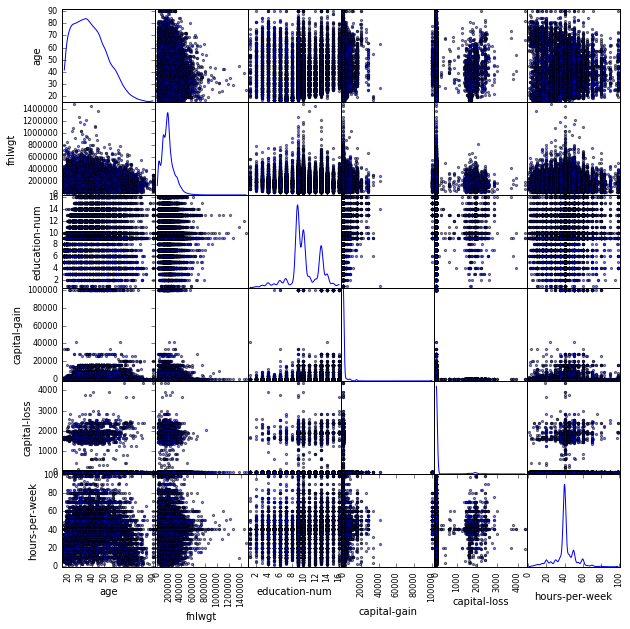

In [7]:
# View a scatter matrix, with the distributions of each feature and pair of features
pd.tools.plotting.scatter_matrix(data,diagonal='kde',figsize=(10,10))
# Also look at the correlation values
print data.corr()

### Feature Scaling

None of the data looks very close to being normally distributed. It might help to use a box-cox transform. There are some variables with a large number of zero values. Some outliers are present and might need to be addressed later.

In [8]:
from scipy.stats import *
for feature in data:
    if data[feature].dtype == 'int64':
        # Compute an optimal norm for a box-cox transform
        normmax_max = boxcox_normmax(data[feature]+1)
        print normmax_max, boxcox_llf(normmax_max,data[feature]+1)
        print "The best exponent for {} is likely {}.".format(feature,normmax_max)
        #fig = plt.figure()
        #ax = fig.add_subplot(111)
        #boxcox_normplot(data[feature]+np.min(data[feature])+1,-5,5,plot=ax)
        #plt.show()
        # If the optimal norm is outside the range (0.5, 1.5), do the transformation.
        if abs(1-normmax_max)>.5 and feature is not "target":
            print "transforming ",feature
            data[feature] = boxcox(data[feature]+1,lmbda=normmax_max)
        else:
            print "Close enough, not worth transforming."

0.229435203505 -83598.2316234
The best exponent for age is likely 0.229435203505.
transforming  age
0.42992802281 -373401.018317
The best exponent for fnlwgt is likely 0.42992802281.
transforming  fnlwgt
1.35963804964 -30512.2583276
The best exponent for education-num is likely 1.35963804964.
Close enough, not worth transforming.
0.117267147194 -69405.5606642
The best exponent for capital-gain is likely 0.117267147194.
transforming  capital-gain
0.795419829354 -154512.909156
The best exponent for capital-loss is likely 0.795419829354.
Close enough, not worth transforming.
0.941772704616 -81858.7146037
The best exponent for hours-per-week is likely 0.941772704616.
Close enough, not worth transforming.


One point I noticed while implementing this is that `boxcox_normmax` and `boxcox` both produce suggested values for lambda, but they optimize different metrics. It might be worth considering whether the suggested values are similar--if not, it could be a sign that the Box-Cox transformation is inappropriate.

I would like to find some good systematic ways of dealing with weirdly distributed features--especially features where the 25th and 75 percentiles are equal, such as capital-loss and capital-gain. I would conjecture that a logistic function would be appropriate, so that differences in magnitude are accounted for but much less strongly than differences between zero and non-zero (or generally typical and atypical) values. This may be more or less important depending on the classifier used. In particular scaling shouldn't have a significant effect on the decision trees we'll start with.

                     age    fnlwgt  education-num  capital-gain  capital-loss  \
age             1.000000 -0.068875       0.065291      0.129897      0.062187   
fnlwgt         -0.068875  1.000000      -0.041447     -0.002189     -0.007510   
education-num   0.065291 -0.041447       1.000000      0.136469      0.079923   
capital-gain    0.129897 -0.002189       0.136469      1.000000     -0.064034   
capital-loss    0.062187 -0.007510       0.079923     -0.064034      1.000000   
hours-per-week  0.122994 -0.022140       0.148123      0.088281      0.054256   

                hours-per-week  
age                   0.122994  
fnlwgt               -0.022140  
education-num         0.148123  
capital-gain          0.088281  
capital-loss          0.054256  
hours-per-week        1.000000  


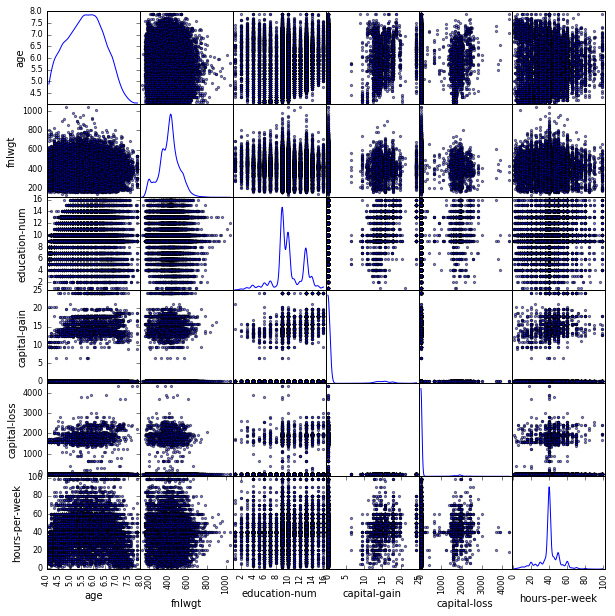

In [9]:
# Display the distributions again to see if they're any better
pd.tools.plotting.scatter_matrix(data,diagonal='kde',figsize=(10,10))

print data.corr()

### Outlier Detection

I prefer to extract outliers from data after doing a Box-Cox transform, since some points that seem like outliers, say, before a log transform, will be much closer to the center of the data when viewed on an appropriate scale. It's also important to consider what is to be done with outliers. They can cause problems in the training phase, but outliers may also be more likely to arise in certain subpopulations. It's generally important not to exclude them from testing sets, since they will arise in deployment.

For now, let's just identify some outliers with a simple loop; we can check them out later on but for now I'll probably leave them in the dataset.

In [10]:
for feature in data._get_numeric_data():
    # Since the features are generally not normally distributed, I'm using a generous definition of outlier
    LowQuintile = np.percentile(data[feature],20)
    HighQuintile = np.percentile(data[feature],80)
    # Using quintiles instead of quartiles
    IQR = HighQuintile - LowQuintile
    print "For the feature {}, the inter-quintile range is from {} to {}.".format(feature,LowQuintile,HighQuintile)
    if IQR != 0:
        #The capital gains and capital losses features are nonzero in less than 20% of people
        outliers = []
        for item in data[feature]:
            # I expanded the range so that low values of education and hours/week aren't highlighted
            if (item < LowQuintile-2*IQR) or (item > HighQuintile + 2*IQR):
                outliers.append(item)
        if len(outliers)>0:
            print outliers, np.max(outliers)

For the feature age, the inter-quintile range is from 4.92568578862 to 6.38425030551.
For the feature fnlwgt, the inter-quintile range is from 335.166250243 to 492.625392243.
[825.78242624131485, 893.60553668776333, 846.16061320917606, 947.85549824593761, 847.38115409514705, 870.52067236713719, 962.18203370672802, 848.88830756780646, 895.59002127141548, 821.42588624993925, 824.6160286491214, 1044.7192253398875, 854.34243970118439, 976.16382089745207, 1007.9103377136403, 1035.7943450639557, 837.92030450349876, 863.23805665946986, 893.60553668776333, 939.78942686325433, 917.1398642334243, 912.82637436099071, 927.20992078775294, 824.6160286491214, 874.09010788782575] 1044.71922534
For the feature education-num, the inter-quintile range is from 9.0 to 13.0.
For the feature capital-gain, the inter-quintile range is from 0.0 to 0.0.
For the feature capital-loss, the inter-quintile range is from 0.0 to 0.0.
For the feature hours-per-week, the inter-quintile range is from 35.0 to 48.0.
[80, 80

It looks like there are a few outliers for final weight, values that are significantly higher than usual. The highest here is 1044, compared to an 80th percentile of just under 500; this is probably meaningful data.

Many of the hours-per-week values are unusual, with values less than 10 and more than 70 showing up. However the highest values are 99; this is actually a number of hours per week that some people work so this data seems pretty safe to keep as is.

## Pre-processing

The first step we'll take in pre-processing the data is to set up one-hot encodings for the categorical variables.

There are a large number. To do this, we'll loop through the features, and for features that are objects we'll fit a label encoder to turn them from class names to class numbers. This will allow us to use the sklearn one-hot encoder. Finally, we'll save these one-hot encodings in new columns whose names are the values of the category.

In [11]:
le = preprocessing.LabelEncoder()

for feature in data:
    if data[feature].dtype =="object":
        print feature
        # Fit a label encoder to each feature
        le.fit(data[feature])
        print le.classes_, len(le.classes_)
        # Reformat the label encoding array
        labelencoded = np.array([[x] for x in le.transform(data[feature])])
        print labelencoded, labelencoded.shape, type(labelencoded)
        # Build a one-hot encoder for the new labels
        oh = preprocessing.OneHotEncoder(sparse=False)
        oh.fit(labelencoded)
        onehots = oh.transform(labelencoded)
        print onehots.shape
        for i in range(len(le.classes_)):
            # One at 
            print "setting one hot values for the feature {}.".format(le.classes_[i])
            data[le.classes_[i]] = onehots[:,i]
        del data[feature]

workclass
[' ?' ' Federal-gov' ' Local-gov' ' Never-worked' ' Private'
 ' Self-emp-inc' ' Self-emp-not-inc' ' State-gov' ' Without-pay'] 9
[[7]
 [6]
 [4]
 ..., 
 [4]
 [4]
 [5]] (32561L, 1L) <type 'numpy.ndarray'>
(32561L, 9L)
setting one hot values for the feature  ?.
setting one hot values for the feature  Federal-gov.
setting one hot values for the feature  Local-gov.
setting one hot values for the feature  Never-worked.
setting one hot values for the feature  Private.
setting one hot values for the feature  Self-emp-inc.
setting one hot values for the feature  Self-emp-not-inc.
setting one hot values for the feature  State-gov.
setting one hot values for the feature  Without-pay.
education
[' 10th' ' 11th' ' 12th' ' 1st-4th' ' 5th-6th' ' 7th-8th' ' 9th'
 ' Assoc-acdm' ' Assoc-voc' ' Bachelors' ' Doctorate' ' HS-grad' ' Masters'
 ' Preschool' ' Prof-school' ' Some-college'] 16
[[ 9]
 [ 9]
 [11]
 ..., 
 [11]
 [11]
 [11]] (32561L, 1L) <type 'numpy.ndarray'>
(32561L, 16L)
setting one ho

It looks like we have a large number of features now. Let's take a look:

In [12]:
print len(data.columns)

106


That's a lot, but it's not a truly ridiculous number. Our dataset is fairly large, and we'll start with decision trees which shouldn't overfit too badly on binary features make up most of these.

That said, in an ideal world, or in a world where we used distance-based predictors like nearest neighbors or SVMs, we would want to use multiple correspondence analysis to do some dimensionality reduction. There's one distribution of this [here](https://pypi.python.org/pypi/mca), but I haven't tried it out.

We could also use PCA, but our focus here is going to be on having an interpretable model, and PCA will obscure that. We don't need to do any linear feature scaling right now (in fact even the box-cox scaling was a bit extraneous, but it might have been important in detecting outliers in the data), however I'll apply standard scaling for convenience in case we want to use any methods for which it might be important.

For now we can move on.

## Cross Validation

Let's start with a very basic stratified train/test split, then use grid search to find an appropriate maximum depth for a decision tree.

In [13]:
scale = preprocessing.StandardScaler()

data = pd.DataFrame(scale.fit_transform(data),columns=list(data))

X_train, X_test, y_train, y_test = cross_validation.train_test_split(data,y['target'],stratify=y)

In [14]:
clf = tree.DecisionTreeClassifier()
param = {'max_depth':range(1,15)}

grid = grid_search.GridSearchCV(clf,param)

grid.fit(X_train,y_train)
preds = grid.predict(X_test)

print grid.score(X_test,y_test)
print grid.best_params_

0.854317651394
{'max_depth': 7}


On the face of it, this seems like a pretty reasonable result. 85% accuracy and a maximum depth in the middle of our range. We could improve this further with boosting, but let's stick with the simple decision tree for now, since it will make it easy to understand the sorting method. In fact, let's build a visual representation of the tree and examine the first parts of it.
|
### Visualizing the decision method

In [16]:
clf = grid.best_estimator_.tree_

# This display works nicely for OS X but I was unable to replicate it in Windows due to errors with GraphViz

# The following analysis was based on that run; the image can be found as firstdecisiontree.png

'''
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydot
dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names = list(data),
                         filled=True, rounded=True, max_depth=3, 
                         special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
#'''

'\nfrom sklearn.externals.six import StringIO\nfrom IPython.display import Image\nimport pydot\ndot_data = StringIO()  \ntree.export_graphviz(clf, out_file=dot_data,  \n                         feature_names = list(data),\n                         filled=True, rounded=True, max_depth=3, \n                         special_characters=True)  \ngraph = pydot.graph_from_dot_data(dot_data.getvalue())  \nImage(graph.create_png())\n#'

Note that the more common class in the data is those who made less than 50k per year at the time of data collection. Orange nodes represent those dominated by lower earners, whereas bluer nodes indicate those dominated by higher earners.

There are a few nodes we can see here that are less certain than the others--these are visually identifiable as the calmer colors, but also by examining their impurity scores.

The most difficult predictions are in cases when:
- The subject is married, has few or no capital gains, and:
    - has 12 years or less (high school graduate or less) of education
    - or has few capital losses
    
This isn't a very clear picture, but it is a nice beginning to see what sorts of features are important. It's interesting to see capital gains arising; presumably these sorts of "investment" features are overwhelmingly present in richer subjects.

It also seems like that many of the high priority features can work reasonably as a proxy for age--marriage becomes more likely as time goes on, as do the presence of capital investments.

#### Where do we make bad decisions?

One of the most important reasons to understand the way our decisions are made is to understand where our system will fail. Let's further this analysis by picking out the specific items on which our algorithm has classified incorrectly.

In [18]:
wrong_indices = []

for i in range(len(preds)):
    if preds[i]!=np.array(y_test)[i]:
        wrong_indices.append(i)
        
print X_test.iloc[wrong_indices].describe()

               age       fnlwgt  education-num  capital-gain  capital-loss  \
count  1186.000000  1186.000000    1186.000000   1186.000000   1186.000000   
mean      0.438302     0.000111       0.309490     -0.168095     -0.075028   
std       0.740559     0.997320       0.894535      0.642007      0.816566   
min      -1.957784    -2.455568      -2.752257     -0.295552     -0.216660   
25%      -0.139386    -0.621061      -0.420060     -0.295552     -0.216660   
50%       0.443334     0.053748      -0.031360     -0.295552     -0.216660   
75%       0.949323     0.545719       1.134739     -0.295552     -0.216660   
max       2.792850     3.611274       2.300838      4.499658      6.617867   

       hours-per-week            ?   Federal-gov    Local-gov   Never-worked  \
count     1186.000000  1186.000000   1186.000000  1186.000000   1.186000e+03   
mean         0.346848    -0.001495      0.159671    -0.007685  -1.466381e-02   
std          0.918114     0.994968      1.365409     0.98

This is a bit opaque; we can compare it to the distribution of our original variables by examination, but with the number of variables there are here it's probably best to run through with some t-tests, to see which distributions are significantly different from the original distribution.

I originally ran this code just looking for p-values less than .05, but the t-tests are very sensitive to small changes in distributions and it gave an unreadably large number of results. Because of that I've added a measure to try to estimate something like the "z-score" of the difference, dividing the difference of means by the standard deviation of the original distribution to make sure there's a noticeable difference.

In [19]:
from scipy.stats import ttest_ind

for feature in X_test:
    t,p = ttest_ind(X_test[feature],X_test.iloc[wrong_indices][feature])
    meandiff = np.mean(X_test[feature])-np.mean(X_test.iloc[wrong_indices][feature])
    stdev = np.std(X_test[feature])
    if stdev==0:
        stdev +=1
    zsc = np.abs(meandiff/stdev)
    if (p < .05 and zsc > .5) or (p<.001 and zsc > .1):
        print "------{}--------".format(feature)
        print "Independent t-test of the feature {} gave a p-value of {:.4f}.".format(feature,p)
        print "The difference in mean values was {:.4f}.".format(meandiff)
        print "For reference, the standard deviation of the feature was {:.4f} in the original dataset.".format(stdev)
        print "That is similar to a z-score of {:.4f}.".format(zsc)
        

------age--------
Independent t-test of the feature age gave a p-value of 0.0000.
The difference in mean values was -0.4386.
For reference, the standard deviation of the feature was 1.0000 in the original dataset.
That is similar to a z-score of 0.4386.
------education-num--------
Independent t-test of the feature education-num gave a p-value of 0.0000.
The difference in mean values was -0.3096.
For reference, the standard deviation of the feature was 0.9921 in the original dataset.
That is similar to a z-score of 0.3121.
------capital-gain--------
Independent t-test of the feature capital-gain gave a p-value of 0.0000.
The difference in mean values was 0.1692.
For reference, the standard deviation of the feature was 1.0014 in the original dataset.
That is similar to a z-score of 0.1689.
------hours-per-week--------
Independent t-test of the feature hours-per-week gave a p-value of 0.0000.
The difference in mean values was -0.3371.
For reference, the standard deviation of the feature w

Finally we can see that there are a huge number of differences between the overall makeup of the testing set, and the parts of the testing set on which our algorithm performed poorly.

To summarize, those uncorrectly predicted were:

- Older, by around 7 years (after reversing the box-cox transform)
- More educated by around .7 years
- Less likely to have capital gains
- Work an average of 4 more hours per week
- More likely to work for the government or to be self-employed, versus working for a private institution
- More likely to have a bachelors degree and less likely to have left school in 10th or 11th grade
- Less likely to be divorced, never married, or separated
- More likely to have a husband
- Less likely to have children
- More likely to be male than female

Notably bad predictions on the test set were 83% men, compared with 67% in the overall set!

In [20]:
print X_test[" Male"].describe()
print X_test.iloc[wrong_indices][" Male"].describe()

count    8141.000000
mean       -0.009399
std         1.003392
min        -1.422331
25%        -1.422331
50%         0.703071
75%         0.703071
max         0.703071
Name:  Male, dtype: float64
count    1186.000000
mean        0.350032
std         0.791354
min        -1.422331
25%         0.703071
50%         0.703071
75%         0.703071
max         0.703071
Name:  Male, dtype: float64


There is one important difference between some of these missed predictions and others, which is the direction in which our predictions were off. Was age too heavily weighted, so that our algorithm had trouble predicting poorer older subjects? Are there gendered pay gaps for certain jobs that our tree wasn't able to learn, resulting in some men being less likely to be predicted as higher earners? We could speculate a lot, but it's better to look to the data for answers.

In [21]:
important_features = [x!=0 for x in grid.best_estimator_.feature_importances_]

important_features = list(data[data.columns[important_features]])

print important_features

['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', ' Federal-gov', ' Local-gov', ' Self-emp-not-inc', ' Married-AF-spouse', ' Married-civ-spouse', ' Exec-managerial', ' Handlers-cleaners', ' Prof-specialty', ' Transport-moving', ' Husband', ' Wife']


In [22]:
false_positives = []
false_negatives = []

for i in range(len(preds)):
    if preds[i]!=np.array(y_test)[i]:
        if preds[i] == 1:
            false_positives.append(i)
        if preds[i] == 0:
            false_negatives.append(i)
         
false_negatives = X_test[important_features].iloc[false_negatives]
false_positives = X_test[important_features].iloc[false_positives]
#print false_positives.describe()
#print false_negatives.describe()

print "There were {} false positives overall, and {} false negatives.".format(len(false_positives.index),len(false_negatives.index))

dtdifffeatures = []

for feature in important_features:
    t,p = ttest_ind(false_positives[feature],false_negatives[feature])
    posmean = np.mean(false_positives[feature])
    negmean = np.mean(false_negatives[feature])
    meandiff = posmean - negmean
    stdev = np.std(X_test[feature])
    if stdev==0:
        stdev +=1
    zsc = np.abs(meandiff/stdev)
    if (p < .05 and zsc > .5) or (p<.001 and zsc > .1):
        dtdifffeatures.append(feature)
        print "------{}--------".format(feature)
        print "Independent t-test of the feature {} gave a p-value of {:.4f}.".format(feature,p)
        print "False positives had a mean value of {},".format(posmean)
        print "While false negatives had a mean value of {}.".format(negmean)
        print "That is similar to a z-score of {:.4f}.".format(zsc)
    

There were 262 false positives overall, and 924 false negatives.
------education-num--------
Independent t-test of the feature education-num gave a p-value of 0.0000.
False positives had a mean value of 1.29496607857,
While false negatives had a mean value of 0.0300578746201.
That is similar to a z-score of 1.2750.
------ Married-civ-spouse--------
Independent t-test of the feature  Married-civ-spouse gave a p-value of 0.0000.
False positives had a mean value of 0.938104651331,
While false negatives had a mean value of 0.649313837375.
That is similar to a z-score of 0.2893.
------ Prof-specialty--------
Independent t-test of the feature  Prof-specialty gave a p-value of 0.0000.
False positives had a mean value of 0.626565809863,
While false negatives had a mean value of 0.00167995901296.
That is similar to a z-score of 0.6249.


First, note that there are three times as many false negatives as false positives! This actually isn't that remarkable though, since the dataset is unbalanced by about 2:1 to start with.

Notably false positives had much more education than false negatives--this seems natural enough since in general education is probably strongly predictive of income. This is reiterated in the classes of "highest educational level obtained," where we can see that false positives consisted of 67% bachelor's holders and 17% master's holders, while false negatives were 38% high school grads and 29% had some college.

Those working in crafts and repairs were more likely to be "undervalued" by the algorithm, whereas those with a professional specialty were more likely to be "overvalued." The algorithm also seems to have failed to account for the differences between countries--in particular it estimated higher incomes for those living in India, and in general false positives are much more likely not to be from the US.

### Checking against another classifier

Next, let's check out another simple method and see how it fairs. In this case, we'll try logistic regression.

In [23]:
clf = linear_model.LogisticRegression()
param = {'C':[10**x for x in range(-5,5)]}

grid = grid_search.GridSearchCV(clf,param)

grid.fit(X_train,y_train)
preds = grid.predict(X_test)

print grid.score(X_test,y_test)
print grid.best_params_

0.845719199116
{'C': 10}


In [24]:
topperc = np.percentile(np.abs(grid.best_estimator_.coef_),75)-.01

important_feature_index = [np.abs(x)>topperc for x in grid.best_estimator_.coef_[0]]
print important_feature_index
print "-------"
important_features = list(data[data.columns[important_feature_index]])

print important_features

[True, False, True, True, True, True, False, True, False, False, True, False, False, False, True, False, False, False, False, False, False, True, False, False, True, False, False, False, True, False, False, True, False, True, False, True, True, False, False, False, False, True, True, False, False, True, True, True, False, True, True, False, False, True, False, True, False, True, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False]
-------
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', ' Federal-gov', ' Private', ' Without-pay', ' 9th', ' Bachelors', ' Preschool', ' Divorced', ' Married-civ-spouse', ' Never-married', ' Separated', ' Exec-managerial', ' Farming-fishing', ' Other-service

In [25]:
false_positives = []
false_negatives = []

for i in range(len(preds)):
    if preds[i]!=np.array(y_test)[i]:
        if preds[i] == 1:
            false_positives.append(i)
        if preds[i] == 0:
            false_negatives.append(i)
         
false_negatives = X_test[important_features].iloc[false_negatives]
false_positives = X_test[important_features].iloc[false_positives]
#print false_positives.describe()
#print false_negatives.describe()

print "There were {} false positives overall, and {} false negatives.".format(len(false_positives.index),len(false_negatives.index))

logdifffeatures = []

for feature in important_features:
    t,p = ttest_ind(false_positives[feature],false_negatives[feature])
    posmean = np.mean(false_positives[feature])
    negmean = np.mean(false_negatives[feature])
    meandiff = posmean - negmean
    stdev = np.std(X_test[feature])
    if stdev==0:
        stdev +=1
    zsc = np.abs(meandiff/stdev)
    if (p < .05 and zsc > .5) or (p<.001 and zsc > .1):
        logdifffeatures.append(feature)
        print "------{}--------".format(feature)
        print "Independent t-test of the feature {} gave a p-value of {:.4f}.".format(feature,p)
        print "False positives had a mean value of {},".format(posmean)
        print "While false negatives had a mean value of {}.".format(negmean)
        print "That is similar to a z-score of {:.4f}.".format(zsc)


There were 445 false positives overall, and 811 false negatives.
------age--------
Independent t-test of the feature age gave a p-value of 0.0003.
False positives had a mean value of 0.517262316372,
While false negatives had a mean value of 0.353503156573.
That is similar to a z-score of 0.1638.
------education-num--------
Independent t-test of the feature education-num gave a p-value of 0.0000.
False positives had a mean value of 0.739924791161,
While false negatives had a mean value of 0.0251955246516.
That is similar to a z-score of 0.7205.
------capital-gain--------
Independent t-test of the feature capital-gain gave a p-value of 0.0000.
False positives had a mean value of 0.360591737441,
While false negatives had a mean value of -0.073683763636.
That is similar to a z-score of 0.4337.
------capital-loss--------
Independent t-test of the feature capital-loss gave a p-value of 0.0001.
False positives had a mean value of 0.225814342375,
While false negatives had a mean value of -0.03

In [26]:
logimp = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', ' Federal-gov', ' Private', ' Self-emp-inc', ' 11th', ' 7th-8th', ' Bachelors', ' Doctorate', ' HS-grad', ' Masters', ' Prof-school', ' Divorced', ' Married-civ-spouse', ' Never-married', ' Exec-managerial', ' Farming-fishing', ' Handlers-cleaners', ' Other-service', ' Prof-specialty', ' Sales', ' Tech-support', ' Husband', ' Own-child', ' Wife', ' Female', ' Male']
dtimp = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', ' Federal-gov', ' Local-gov', ' Self-emp-inc', ' HS-grad', ' Masters', ' Preschool', ' Married-AF-spouse', ' Married-civ-spouse', ' Widowed', ' Adm-clerical', ' Exec-managerial', ' Farming-fishing', ' Handlers-cleaners', ' Prof-specialty', ' Protective-serv', ' Sales', ' Not-in-family', ' Wife', ' Amer-Indian-Eskimo', ' White', ' Female', ' Male', ' India', ' Japan', ' United-States']
print logdifffeatures, dtdifffeatures

print "We chose {} important features from logistic regression, and {} from our decision tree.".format(len(logimp),len(dtimp))

for x in logdifffeatures:
    if x in dtdifffeatures:
        print "{} was different across both classifiers.".format(x)

['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', ' Bachelors', ' Divorced', ' Married-civ-spouse', ' Never-married', ' Exec-managerial', ' Prof-specialty', ' Tech-support', ' Not-in-family', ' Wife'] ['education-num', ' Married-civ-spouse', ' Prof-specialty']
We chose 30 important features from logistic regression, and 31 from our decision tree.
education-num was different across both classifiers.
 Married-civ-spouse was different across both classifiers.
 Prof-specialty was different across both classifiers.


One question we might ask is whether these features are interpreted by the models as overly predictive. Since they result in errors in a specific direction, they might be imperfect signals of other features, causing the models to overfit. Let's see what happens when we remove these features.

In [27]:

newdata = data[[feature for feature in data if feature not in set(logdifffeatures).intersection(dtdifffeatures)]]
print newdata.head()

        age    fnlwgt  capital-gain  capital-loss  hours-per-week         ?  \
0  0.163220 -1.179675      2.534683      -0.21666       -0.035429 -0.135023   
1  0.889507 -1.089870     -0.295552      -0.21666       -2.222153 -0.135023   
2  0.089836  0.396477     -0.295552      -0.21666       -0.035429 -0.135023   
3  1.066345  0.560841     -0.295552      -0.21666       -0.035429 -0.135023   
4 -0.737954  1.343230     -0.295552      -0.21666       -0.035429 -0.135023   

    Federal-gov   Local-gov   Never-worked   Private     ...        Portugal  \
0     -0.174295   -0.262097      -0.014664 -1.516792     ...       -0.033729   
1     -0.174295   -0.262097      -0.014664 -1.516792     ...       -0.033729   
2     -0.174295   -0.262097      -0.014664  0.659286     ...       -0.033729   
3     -0.174295   -0.262097      -0.014664  0.659286     ...       -0.033729   
4     -0.174295   -0.262097      -0.014664  0.659286     ...       -0.033729   

    Puerto-Rico   Scotland     South    Taiw

In [28]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(newdata,y['target'],stratify=y)

In [29]:
clf = tree.DecisionTreeClassifier()
param = {'max_depth':range(1,15)}

grid = grid_search.GridSearchCV(clf,param)

grid.fit(X_train,y_train)
preds = grid.predict(X_test)

print grid.score(X_test,y_test)
print grid.best_params_

0.855423166687
{'max_depth': 9}


In [32]:
clf = grid.best_estimator_.tree_

# See above notes on graphviz

'''
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydot
dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names = list(data),
                         filled=True, rounded=True, max_depth=3, 
                         special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  
#'''

'\nfrom sklearn.externals.six import StringIO\nfrom IPython.display import Image\nimport pydot\ndot_data = StringIO()  \ntree.export_graphviz(clf, out_file=dot_data,  \n                         feature_names = list(data),\n                         filled=True, rounded=True, max_depth=3, \n                         special_characters=True)  \ngraph = pydot.graph_from_dot_data(dot_data.getvalue())  \nImage(graph.create_png())  \n#'

In [33]:
important_features = [x!=0 for x in grid.best_estimator_.feature_importances_]

important_features = list(newdata[newdata.columns[important_features]])

print important_features

['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week', ' ?', ' Federal-gov', ' Local-gov', ' Self-emp-inc', ' Self-emp-not-inc', ' State-gov', ' 12th', ' Assoc-acdm', ' Assoc-voc', ' Bachelors', ' Doctorate', ' HS-grad', ' Masters', ' Prof-school', ' Some-college', ' Divorced', ' Adm-clerical', ' Craft-repair', ' Exec-managerial', ' Farming-fishing', ' Handlers-cleaners', ' Machine-op-inspct', ' Other-service', ' Sales', ' Tech-support', ' Husband', ' Wife', ' Black', ' Other', ' White', ' Female', ' Male', ' Ecuador', ' Portugal', ' South']


In [34]:
false_positives = []
false_negatives = []

for i in range(len(preds)):
    if preds[i]!=np.array(y_test)[i]:
        if preds[i] == 1:
            false_positives.append(i)
        if preds[i] == 0:
            false_negatives.append(i)
         
false_negatives = X_test[important_features].iloc[false_negatives]
false_positives = X_test[important_features].iloc[false_positives]
#print false_positives.describe()
#print false_negatives.describe()

print "There were {} false positives overall, and {} false negatives.".format(len(false_positives.index),len(false_negatives.index))

dtdifffeatures = []

for feature in important_features:
    t,p = ttest_ind(false_positives[feature],false_negatives[feature])
    posmean = np.mean(false_positives[feature])
    negmean = np.mean(false_negatives[feature])
    meandiff = posmean - negmean
    stdev = np.std(X_test[feature])
    if stdev==0:
        stdev +=1
    zsc = np.abs(meandiff/stdev)
    if (p < .05 and zsc > .5) or (p<.001 and zsc > .1):
        dtdifffeatures.append(feature)
        print "------{}--------".format(feature)
        print "Independent t-test of the feature {} gave a p-value of {:.4f}.".format(feature,p)
        print "False positives had a mean value of {},".format(posmean)
        print "While false negatives had a mean value of {}.".format(negmean)
        print "That is similar to a z-score of {:.4f}.".format(zsc)
    

There were 261 false positives overall, and 916 false negatives.
------ Self-emp-not-inc--------
Independent t-test of the feature  Self-emp-not-inc gave a p-value of 0.0002.
False positives had a mean value of 0.323275906571,
While false negatives had a mean value of 0.0265244460509.
That is similar to a z-score of 0.2996.
------ Assoc-acdm--------
Independent t-test of the feature  Assoc-acdm gave a p-value of 0.0001.
False positives had a mean value of -0.184063763694,
While false negatives had a mean value of 0.116406998997.
That is similar to a z-score of 0.2930.
------ Assoc-voc--------
Independent t-test of the feature  Assoc-voc gave a p-value of 0.0000.
False positives had a mean value of -0.191529148287,
While false negatives had a mean value of 0.195608141568.
That is similar to a z-score of 0.3771.
------ Bachelors--------
Independent t-test of the feature  Bachelors gave a p-value of 0.0000.
False positives had a mean value of 1.29276152639,
While false negatives had a mea

In [35]:
clf = linear_model.LogisticRegression()
param = {'C':[10**x for x in range(-5,5)]}

grid = grid_search.GridSearchCV(clf,param)

grid.fit(X_train,y_train)
preds = grid.predict(X_test)

print grid.score(X_test,y_test)
print grid.best_params_

0.847561724604
{'C': 0.01}


In [36]:
topperc = np.percentile(np.abs(grid.best_estimator_.coef_),75)-.01

important_feature_index = [np.abs(x)>topperc for x in grid.best_estimator_.coef_[0]]
print important_feature_index
print "-------"
important_features = list(newdata[newdata.columns[important_feature_index]])

print important_features

[True, False, True, True, True, False, True, False, False, True, True, False, False, False, True, True, False, False, False, True, True, False, False, True, True, True, True, False, True, False, True, False, False, True, False, False, False, False, False, True, True, True, True, True, False, False, False, False, False, True, False, False, True, False, True, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
-------
['age', 'capital-gain', 'capital-loss', 'hours-per-week', ' Federal-gov', ' Private', ' Self-emp-inc', ' 10th', ' 11th', ' 7th-8th', ' 9th', ' Bachelors', ' Doctorate', ' HS-grad', ' Masters', ' Prof-school', ' Divorced', ' Never-married', ' Exec-managerial', ' Farming-fishing', ' Handlers-cleaner

In [37]:
false_positives = []
false_negatives = []

for i in range(len(preds)):
    if preds[i]!=np.array(y_test)[i]:
        if preds[i] == 1:
            false_positives.append(i)
        if preds[i] == 0:
            false_negatives.append(i)
         
false_negatives = X_test[important_features].iloc[false_negatives]
false_positives = X_test[important_features].iloc[false_positives]
#print false_positives.describe()
#print false_negatives.describe()

print "There were {} false positives overall, and {} false negatives.".format(len(false_positives.index),len(false_negatives.index))

logdifffeatures = []

for feature in important_features:
    t,p = ttest_ind(false_positives[feature],false_negatives[feature])
    posmean = np.mean(false_positives[feature])
    negmean = np.mean(false_negatives[feature])
    meandiff = posmean - negmean
    stdev = np.std(X_test[feature])
    if stdev==0:
        stdev +=1
    zsc = np.abs(meandiff/stdev)
    if (p < .05 and zsc > .5) or (p<.001 and zsc > .1):
        logdifffeatures.append(feature)
        print "------{}--------".format(feature)
        print "Independent t-test of the feature {} gave a p-value of {:.4f}.".format(feature,p)
        print "False positives had a mean value of {},".format(posmean)
        print "While false negatives had a mean value of {}.".format(negmean)
        print "That is similar to a z-score of {:.4f}.".format(zsc)


There were 439 false positives overall, and 802 false negatives.
------age--------
Independent t-test of the feature age gave a p-value of 0.0001.
False positives had a mean value of 0.526247771373,
While false negatives had a mean value of 0.348109993116.
That is similar to a z-score of 0.1796.
------capital-gain--------
Independent t-test of the feature capital-gain gave a p-value of 0.0000.
False positives had a mean value of 0.482414113784,
While false negatives had a mean value of -0.0956646902812.
That is similar to a z-score of 0.5809.
------capital-loss--------
Independent t-test of the feature capital-loss gave a p-value of 0.0001.
False positives had a mean value of 0.312196787325,
While false negatives had a mean value of 0.010153595193.
That is similar to a z-score of 0.2999.
------hours-per-week--------
Independent t-test of the feature hours-per-week gave a p-value of 0.0000.
False positives had a mean value of 0.509913941321,
While false negatives had a mean value of 0.2

In [41]:
for x in logdifffeatures:
    if x in dtdifffeatures:
        print "{} was different across both classifiers.".format(x)

 Bachelors was different across both classifiers.
 HS-grad was different across both classifiers.
 Masters was different across both classifiers.
 Prof-school was different across both classifiers.
 Husband was different across both classifiers.


In [46]:
import time
t0 = time.time()

clf = neighbors.KNeighborsClassifier()
param = {'n_neighbors':[3,6],'weights':['uniform','distance']}

grid = grid_search.GridSearchCV(clf,param)

print t0-time.time()

grid.fit(X_train,y_train)
t1=time.time()
print "training time was: {}".format(t1-t0)
preds = grid.predict(X_test)

print "prediction time was: {}".format(time.time()-t1)
print grid.score(X_test,y_test)
print grid.best_params_



0.0
training time was: 299.635999918
prediction time was: 31.8410000801
0.824591573517
{'n_neighbors': 6, 'weights': 'uniform'}
